In [1]:
from datasets import load_dataset, load_metric
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

## Samples from the Train dataset

In [4]:
train_df = pd.DataFrame(train_dataset)
train_df.head(5)

,tokens,pos_tags,ner_tags
0,"[For, this, purpose, the, Gothenburg, Young, P...","[ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PRO...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I..."
1,"[The, following, physiological, traits, were, ...","[DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, N...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF..."
2,"[Minor, H, antigen, alloimmune, responses, rea...","[ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, ...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,..."
3,"[EPI, =, Echo, planar, imaging, .]","[PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]"
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[ADV, PUNCT, PROPN, PUNCT, VERB, PROPN, NOUN, ...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O..."


### Label Encoding

In [5]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

train_label_list = []
for sample in train_dataset["ner_tags"]:
    train_label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in val_dataset["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in test_dataset["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])


# Calculating `ner_tag` frequency in all datasets(train, validation, and test)

In [6]:
label_list_train = []
label_list_val = []
label_list_test = []
for i in train_label_list:
    label_list_train += i

for i in val_label_list:
    label_list_val += i

for i in test_label_list:
    label_list_test += i

In [7]:
count_train = Counter(label_list_train)
count_val = Counter(label_list_val)
count_test = Counter(label_list_test)
numbers = range(4)

def bar_chart(count,dataset):   
    occurrences = [count[number] for number in numbers]
    
    plt.bar(numbers, occurrences, tick_label=[str(label) for label in label_encoding.keys()])
    plt.xlabel('Labels')
    plt.ylabel('Occurrences')
    plt.title(f'Occurrences of Each Label of {dataset}')
    plt.show()

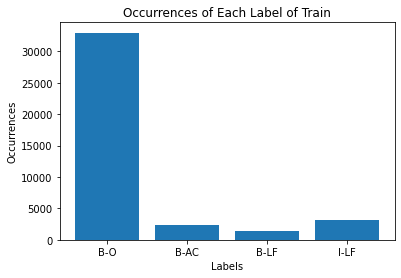

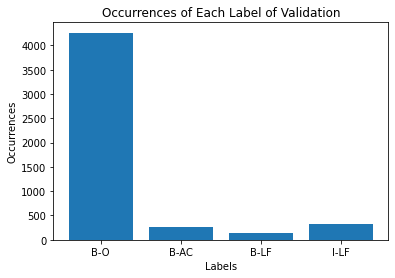

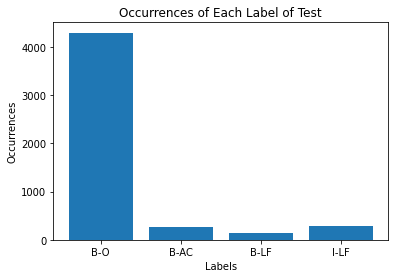

In [8]:
bar_chart(count_train,'Train')
bar_chart(count_val,'Validation')
bar_chart(count_test, 'Test')

# Number of tokens in each dataset

In [9]:
labels_df = pd.DataFrame({
    'Labels':[i for i in label_encoding.keys()],
    'Train':[count_train[i] for i in range(len(count_train))],
    'Validation':[count_val[i] for i in range(len(count_val))],
    'Test':[count_test[i] for i in range(len(count_test))]})

In [10]:
labels_df['Total'] = labels_df[['Train','Validation','Test']].sum(axis =1)
labels_df.head()

,Labels,Train,Validation,Test,Total
0,B-O,32971,4261,4292,41524
1,B-AC,2336,263,270,2869
2,B-LF,1462,149,150,1761
3,I-LF,3231,327,288,3846


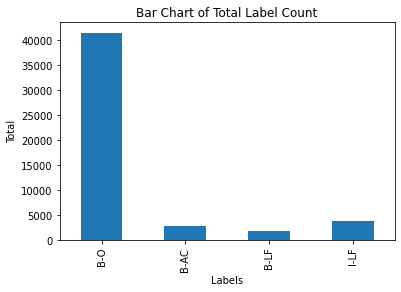

In [11]:
labels_df.plot(kind='bar', x='Labels', y='Total', legend=False)
plt.xlabel('Labels')
plt.ylabel('Total')
plt.title('Bar Chart of Total Label Count')
plt.show()

# Count of Long form by token length

In [12]:
def analyze_sequences(mylist):
    sequence_counts = {}
    
    for sublist in mylist:
        i = 0
        while i < len(sublist):
            if sublist[i] == 2:
                # Start a new sequence with '2'
                sequence_length = 1
                i += 1  # Move to the next element after '2'
                
                # Check if '3's follow the '2'
                while i < len(sublist) and sublist[i] == 3:
                    sequence_length += 1
                    i += 1
                
                # If sequence is longer than 5, limit it to 5 (based on original logic)
                if sequence_length > 5:
                    sequence_length = 5

                # Update the dictionary with the found sequence length
                if sequence_length in sequence_counts:
                    sequence_counts[sequence_length] += 1
                else:
                    sequence_counts[sequence_length] = 1
            else:
                i += 1

    return sequence_counts

In [13]:
sequence_counts = analyze_sequences(train_label_list)
val_counts = analyze_sequences(val_label_list)
test_counts = analyze_sequences(test_label_list)

for i in range(1,6):
    sequence_counts[i] = sequence_counts[i] + val_counts[i] + test_counts[i]
print(sequence_counts)

{5: 263, 2: 467, 3: 560, 1: 196, 4: 275}


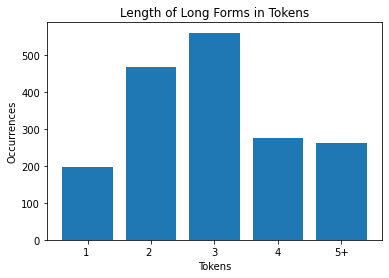

In [14]:
occurrences = [sequence_counts[i] for i in range(1,6)]

plt.bar(range(5), occurrences, tick_label=['1 ','2 ','3','4','5+'])
plt.xlabel('Tokens')
plt.ylabel('Occurrences')
plt.title('Length of Long Forms in Tokens')
plt.show()

## Count of Unique long forms by token length

In [15]:
def unique_lf(dataset):
    unique_tokens = set()
    
    for tokens, ner_tags in zip(dataset['tokens'], dataset['ner_tags']):
        i = 0
        while i < len(tokens):
            if ner_tags[i] == 'B-LF':
                temp_list = [tokens[i]]
                i += 1
                while i < len(tokens) and ner_tags[i] == 'I-LF':
                    temp_list.append(tokens[i])
                    i += 1
                unique_tokens.add(" ".join(temp_list))
            else:
                i += 1
    return unique_tokens


In [16]:
unique_dataset = set()
unique_dataset.update(unique_lf(train_dataset))
unique_dataset.update(unique_lf(val_dataset))
unique_dataset.update(unique_lf(test_dataset))

unique_list = [sentence.split() for sentence in unique_dataset]

In [17]:
sequence_counts = {}
for i in unique_list:
    length = len(i)
    if length > 5: length = 5
    if length in sequence_counts:
        sequence_counts[length] += 1
    else:
        sequence_counts[length] = 1

In [18]:
sequence_counts

{3: 472, 2: 357, 5: 246, 1: 168, 4: 240}

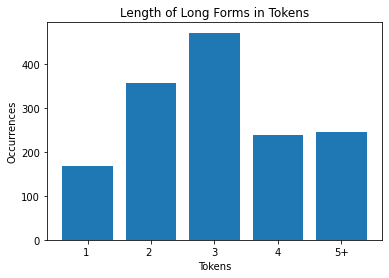

In [19]:
occurrences = [sequence_counts[i] for i in range(1,6)]

plt.bar(range(5), occurrences, tick_label=['1 ','2 ','3','4','5+'])
plt.xlabel('Tokens')
plt.ylabel('Occurrences')
plt.title('Length of Long Forms in Tokens')
plt.show()

# Count of Abbreviations by character length

In [20]:
def char_count(dataset):
    count = {}
    for tokens, ner_tags in zip(dataset['tokens'], dataset['ner_tags']):
        for token, tag in zip(tokens, ner_tags):
            if tag == 'B-AC':
                token_length = min(len(token), 6)
                count[token_length] = count.get(token_length, 0) + 1
    return count

In [21]:
train_char = char_count(train_dataset)
val_char = char_count(val_dataset)
test_char = char_count(test_dataset)
char_dict = {}

for i in range(1,7):
    char_dict[i] = train_char[i] + val_char[i] + test_char[i]

In [22]:
char_dict

{1: 52, 2: 607, 3: 1117, 4: 571, 5: 258, 6: 264}

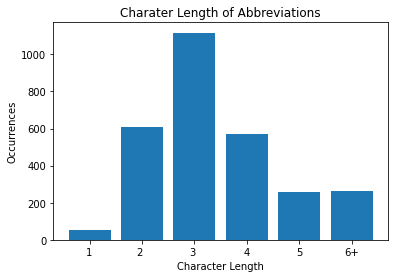

In [23]:
occurrences = [char_dict[i] for i in range(1,7)]

plt.bar(range(6), occurrences, tick_label=['1','2 ','3 ','4','5','6+'])
plt.xlabel('Character Length')
plt.ylabel('Occurrences')
plt.title('Charater Length of Abbreviations')
plt.show()

## Count of unique Abbreviations by character length

In [24]:
def unique_char_count(dataset):
    temp_set = set()
    for tokens, ner_tags in zip(dataset['tokens'], dataset['ner_tags']):
        for token, tag in zip(tokens, ner_tags):
            if tag == 'B-AC':
                temp_set.add(token) 
    return temp_set

In [25]:
char_set = set()
char_set.update(unique_char_count(train_dataset))
char_set.update(unique_char_count(val_dataset))
char_set.update(unique_char_count(test_dataset))

unique_char_dict = {}
for i in char_set:
    token_length = min(len(i), 6)
    unique_char_dict[token_length] = unique_char_dict.get(token_length, 0) + 1

In [26]:
unique_char_dict

{3: 709, 2: 258, 4: 430, 5: 203, 6: 233, 1: 30}

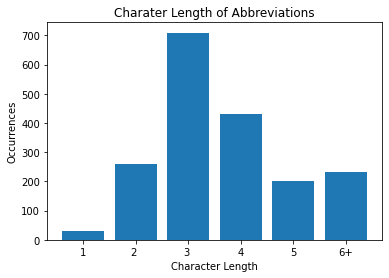

In [27]:
occurrences = [unique_char_dict[i] for i in range(1,7)]

plt.bar(range(6), occurrences, tick_label=['1','2 ','3 ','4','5','6+'])
plt.xlabel('Character Length')
plt.ylabel('Occurrences')
plt.title('Charater Length of Abbreviations')
plt.show()